In [1]:
# Required imports
import os
import shutil
import time
import cv2
import numpy as np
import math
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import seaborn as sns

# Constants
Image.MAX_IMAGE_PIXELS = None
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
IMAGE_EXT = '.jpg'
BASE_PATH = '/workspace/0728tot/last_experiment/'
RESIZE_DIMS = (224, 224)
NUM_CLASSES = 2


!ln -s /workspace/0728tot/last_experiment/resnet.py resnet.py
from resnet import *

ln: failed to create symbolic link 'resnet.py': File exists


2023-10-25 17:35:34.507112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Directory paths

# Folders containing original DUV WSI
ORIGINAL_IMAGES_DIR = os.path.join(BASE_PATH, 'unknown_DUV_WSI')

# Folder containing reshaped DUV WSI
RESHAPED_IMAGES_DIR = os.path.join(BASE_PATH, 'reshaped_unknown_DUV_WSI')

# Folders processing the GradCAM++ results
RAW_MAP_DIR = os.path.join(BASE_PATH, 'unknown_DenseNet169ImageNetGradCAM_2')
FINAL_HEAT_MAP_DIR = os.path.join(BASE_PATH, 'unknown_DenseNet169ImageNetGradCAM')
FINAL_OVERLAY_HEAT_MAP_DIR = os.path.join(BASE_PATH, 'unknown_DUV_finalheatmap/')

# Folders for holding the GradCAM++ results and patch level results in a grid system
GRADCAM_GRID_MAP_DIR = os.path.join(BASE_PATH, 'unknown_gradcam_gridmap')
PRED_GRID_MAP_DIR = os.path.join(BASE_PATH, 'unknown_patch_gridmap')

# Folders for processing the patch level and GradCAM++ results for visualization purposes
PROCESS_PATCHES_DIR = os.path.join(BASE_PATH,'unknown_process_patchmaps')
BOUNDING_BOXES_OVERLAY_DIR = os.path.join(BASE_PATH,'unknown_bounding_boxes_overlays')

# Folders for patch related info
PATCH_DIR = os.path.join(BASE_PATH, 'unknown_Patches')
PATCH_FEATURES_DIR = os.path.join(BASE_PATH, 'unknown_Patches_features')
PRIOR_PATCH_FEATURES_DIR = os.path.join(BASE_PATH, 'DUV_features')
PRIOR_PATCH_DATA_CSV = os.path.join(BASE_PATH, 'duvdata.csv')

# Folder for getting training splits, an example
SPLIT_DIR = os.path.join(BASE_PATH, 'prior_train_splits')

In [22]:
# Ensure all new patch and prediction directories exist
all_directories = [RAW_MAP_DIR, FINAL_HEAT_MAP_DIR, GRADCAM_GRID_MAP_DIR, PRED_GRID_MAP_DIR, PATCH_DIR, PATCH_FEATURES_DIR]
for directory in all_directories:
    if not os.path.exists(directory):
        os.makedirs(directory)


# Enable matplotlib inline mode for Jupyter Notebook
%matplotlib inline
        
# Helper functions
def create_dataframe(data_folder, is_map_format=False):
    '''Creates a dataframe for the dataset. 
       If is_map_format is True, it uses the logic specific to map format.'''
    data_entries = []
    for root, _, files in os.walk(data_folder):
        for filename in files:
            relative_path = os.path.relpath(root, data_folder)
            file_extension = os.path.splitext(filename)[-1]
            if file_extension == '.jpg':
                try:
                    if is_map_format:
                        name_parts = filename.replace(".", "_").split('_')
                        subject, side, _ = name_parts
                    else:
                        name_parts = filename.split('_')
                        subject = int(name_parts[0].split('.')[0])
                        side = int(name_parts[1].split('.')[0]) if len(name_parts) > 1 else 0
                    full_path = os.path.join(root, filename)
                    entry = {
                        'relative_path': relative_path, 
                        'filename': filename, 
                        'subject': subject, 
                        'side': side, 
                        'full_path': full_path
                    }
                    data_entries.append(entry)
                except:
                    pass
    data_frame = pd.DataFrame(data_entries)
    return data_frame

def save_foreground_image(image_path, output_directory, subject_id, side_id):
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.fastNlMeansDenoising(grayscale_image, None, 25, 7, 21)
    edges_image = cv2.Canny(denoised_image, 100, 100, L2gradient=True)
    x, y, w, h = cv2.boundingRect(edges_image)
    foreground_image = image[y:y+h, x:x+w]
    output_path = os.path.join(output_directory, f"{subject_id}_{side_id}.jpg")
    cv2.imwrite(output_path, foreground_image)

def compute_foreground_ratio(image):
    background_threshold = 5
    return np.mean(image[:, :, 1] >= background_threshold)

dataset_frame = create_dataframe(ORIGINAL_IMAGES_DIR)
dataset_frame = dataset_frame.sort_values('subject')
image_paths = dataset_frame.full_path.to_numpy()
subject_ids = dataset_frame.subject.to_list()
side_ids = dataset_frame.side.to_list()

# Getting the recropped images to reduce processing time
for index in range(len(dataset_frame)):
    save_foreground_image(image_paths[index], RESHAPED_IMAGES_DIR, subject_ids[index], side_ids[index])

In [6]:
# Patch Extraction
subject_side_pairs = [f"{subj}_{side}" for subj, side in zip(subject_ids, side_ids)]
for pair in subject_side_pairs:
    full_patch_directory = os.path.join(PATCH_DIR, f'S{pair}')
    shutil.rmtree(full_patch_directory, ignore_errors=True)
    os.makedirs(full_patch_directory)

processed_frame = create_dataframe(RESHAPED_IMAGES_DIR, is_map_format=True)
processed_frame = processed_frame.sort_values(by=['subject'], ignore_index=True)
processed_image_paths = processed_frame.full_path.to_list()
final_subject_ids = processed_frame.subject.to_numpy()
final_side_ids = processed_frame.side.to_numpy()

patch_width, patch_height = 400, 400
start_time = time.time()

for idx, image_path in enumerate(processed_image_paths):
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    resized_width, resized_height = (math.ceil(dim/400) * 400 for dim in (image_width, image_height))
    resized_image = cv2.resize(image, (resized_width, resized_height), interpolation=cv2.INTER_AREA)

    for x in range(0, resized_width - patch_width + 1, patch_width):
        for y in range(0, resized_height - patch_height + 1, patch_height):
            cropped_image = resized_image[y:y+patch_height, x:x+patch_width]
            if compute_foreground_ratio(cropped_image) > 0.8:
                filename = os.path.join(PATCH_DIR, f'S{final_subject_ids[idx]}_{final_side_ids[idx]}', f'{idx}_{x//patch_width}-{y//patch_height}.png')
                cv2.imwrite(filename, cropped_image)
    print(time.time() - start_time)

8.811657905578613
17.011672973632812
19.407439947128296
21.95302677154541
24.92561936378479
29.61857557296753
39.890738010406494
48.88908624649048
54.881184101104736
61.17561435699463
63.11239051818848
65.61716294288635
70.35196781158447
74.57070779800415
77.53427457809448
79.96434259414673
82.26051473617554
84.26114797592163
88.1029806137085
90.83645367622375
92.14929461479187
93.40744519233704
96.88540887832642
100.29750967025757
106.00837278366089
111.89108872413635
117.11548328399658
123.82678627967834
135.56371593475342
141.87888503074646
142.6039924621582
143.4754159450531
144.8688383102417
148.20301127433777
151.0614960193634
154.23908162117004
156.50515747070312
159.10237216949463
159.90557098388672
161.298588514328
163.14071822166443
166.92461562156677
182.45984768867493
183.28068232536316
185.19795322418213
188.99002265930176
189.32873558998108
190.72538447380066
193.1427035331726
195.5515193939209
200.62160873413086
205.38245820999146
207.2925591468811
209.41530466079712
211

In [3]:
# Load Data
def make_old_dataframe(bh_folder, ext, name_replace_list, column_mapping):
    '''Utility function to create dataframe from dataset'''    
    data_entries = []
    for root, _, files in os.walk(bh_folder):
        for filename in files:
            relative_path = os.path.relpath(root, bh_folder)
            file_extension = os.path.splitext(filename)[-1]
            if file_extension == ext:
                try:
                    full_path = os.path.join(root, filename)  # Compute the full path using the original filename
                    for old, new in name_replace_list:
                        filename = filename.replace(old, new)
                    file_data = filename.replace(ext, "").split('_')
                    row_data = dict(zip(column_mapping, [relative_path, filename, full_path] + file_data))
                    data_entries.append(row_data)
                except:
                    pass
    df = pd.DataFrame(data_entries)
    for col, dtype in zip(column_mapping[3:], ['int'] * len(column_mapping[3:])):
        df[col] = df[col].astype(dtype)
    return df

# Create DataFrames
column_mapping_fold = ['relpath', 'filename', 'fullpath', 'subject']
column_mapping_patch = ['subject', 'filename', 'fullpath', 'seq', 'y', 'x']

fold_df = make_old_dataframe(SPLIT_DIR, '.jpg', [("T", "")], column_mapping_fold)
duv_patch_df = make_old_dataframe(PATCH_DIR, '.png', [("-", "_")], column_mapping_patch)

# Split Data
test_split = [list(fold_df[fold_df['relpath'] == str(i)].subject.to_list()) for i in range(1, 6)]

In [4]:
import re

def make_diffusion_dataframe(malignant_folder, normal_folder, ext, column_mapping):
    '''Utility function to create dataframe from two datasets'''    
    data_entries = []
    
    for folder, label in [(malignant_folder, "malignant"), (normal_folder, "normal")]:
        for root, _, files in os.walk(folder):
            for filename in files:
                relative_path = os.path.relpath(root, folder)
                file_extension = os.path.splitext(filename)[-1]
                if file_extension == ext:
                    try:
                        full_path = os.path.join(root, filename)  # Compute the full path using the original filename
                        
                        # Extract numbers from the filename using regex
                        numbers = re.findall(r"\d+", filename)
                        primary_number, secondary_number = numbers if len(numbers) == 2 else (numbers[0], None)
                        
                        row_data = dict(zip(column_mapping, [relative_path, filename, full_path, label, primary_number, secondary_number]))
                        data_entries.append(row_data)
                    except:
                        pass
                        
    df = pd.DataFrame(data_entries)
    df['primary_number'] = df['primary_number'].astype(int)
    df['secondary_number'] = df['secondary_number'].astype(int)  # It can be NaN
    return df

# Modified column mapping to accommodate the changes
column_mapping = ['relpath', 'filename', 'fullpath', 'label', 'primary_number', 'secondary_number']

# Example usage
diffusion_patch_df = make_diffusion_dataframe("diffusion_malignant", "diffusion_normal", ".tif", column_mapping)

DIF_PATCH_FEATURES_DIR = os.path.join(BASE_PATH, 'diffusion_features')


In [4]:
# # # Feature Extraction
# # You will have to restart kernel you don't have enough GPU VRAM, check with !nvidia-smi

# if 'RNObject' not in locals():
#     print('Making ResNet object.')
#     RNObject = ResNetClass()

# res50 = RNObject.get_resnet_model(layer_name='avg_pool')
# RNObject.save_resnet_predictions(diffusion_patch_df, DIF_PATCH_FEATURES_DIR, res50, verbose=1, mode=1)

In [5]:
# Add Features to DataFrame
def add_features_to_df(df, save_folder, version):
    features = [np.load(os.path.join(save_folder, name + '.npy')).squeeze() for name in df[str(version)]]
    df['features'] = features
    return df
    
duv_patch_df = add_features_to_df(duv_patch_df, PATCH_FEATURES_DIR, version='filename')
diffusion_patch_df = add_features_to_df(diffusion_patch_df, DIF_PATCH_FEATURES_DIR, version='filename')

In [6]:
# Load Features from Previous Analysis
prior_data_df = pd.read_csv(PRIOR_PATCH_DATA_CSV)

prior_data_df['subject'] = [int(x.replace("S", "")) for x in prior_data_df.relpath]
prior_data_df = add_features_to_df(prior_data_df, PRIOR_PATCH_FEATURES_DIR, 'name')

In [7]:
diffusion_patch_df['label'].replace({'malignant': 'M', 'normal': 'B'}, inplace=True)

In [8]:
# Load data and extract information
df = pd.read_excel(os.path.join(BASE_PATH, "Specimen Tracking Log and Financial Logs.xlsx"), sheet_name=0)
extracted_df = df[["Sample #", "Type of Specimen (normal, IDC, ICL, tumor + adj normal)"]].copy()
extracted_df.columns = ["Patient Subject ID", "Specimen Type"]

# Define the list of desired specimen types
desired_specimen_types = [
    "breast cancer",
    "IMC: Invasive Mucinous",
    "IDC",
    "IMC: IDC with lobular features",
    "IMC: ILC",
    "ILC",
    "Invasive lobular carcinoma",
    "fibroadenoma",
    "normal breast tissue",
    "normal"
]

# Filter the dataframe
filtered_df = extracted_df[extracted_df['Specimen Type'].isin(desired_specimen_types)]

def get_cancer_status(specimen_type):
    benign_types = ["normal", "fibroadenoma", "normal breast tissue"]
    if specimen_type in benign_types:
        return 'B'
    else:
        return 'M'

filtered_df['Cancer Status'] = filtered_df['Specimen Type'].apply(get_cancer_status)

/tmp/ipykernel_687076/3494575485.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cancer Status'] = filtered_df['Specimen Type'].apply(get_cancer_status)


In [11]:
duv_patch_df

,subject,filename,fullpath,seq,y,x,features
0,S82_2,44_13_8.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,13,8,"[0.5293978, 0.0, 0.031304058, 0.024001367, 1.8..."
1,S82_2,44_11_2.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,11,2,"[0.9896475, 0.0, 0.0, 0.22777031, 0.048390884,..."
2,S82_2,44_0_3.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,0,3,"[0.2669169, 0.0, 0.13216071, 0.0844125, 0.0818..."
3,S82_2,44_6_4.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,6,4,"[1.4421592, 0.0, 0.16970389, 0.95852107, 0.241..."
4,S82_2,44_2_4.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,2,4,"[0.9964333, 0.2090966, 0.27250272, 0.001423189..."
...,...,...,...,...,...,...,...
30148,S92_1,67_5_15.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,5,15,"[0.62066966, 0.0, 0.0, 0.0, 0.004477279, 0.0, ..."
30149,S92_1,67_15_12.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,15,12,"[3.6157215, 0.0, 0.029128622, 0.0037973328, 0...."
30150,S92_1,67_20_10.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,20,10,"[3.205265, 0.00070112577, 0.028292198, 0.0, 0...."
30151,S92_1,67_30_16.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,30,16,"[0.038404655, 0.0055522625, 0.0, 0.0, 0.0, 0.0..."


In [9]:
duv_patch_df['subject'] = duv_patch_df['subject'].str.replace('S', '')
duv_patch_df['actual_subject'] = duv_patch_df['subject'].str.split('_').str[0].astype(int)
duv_patch_df = duv_patch_df[duv_patch_df['actual_subject'].isin(filtered_df['Patient Subject ID'].values)]

In [10]:
duv_patch_df

,subject,filename,fullpath,seq,y,x,features,actual_subject
0,82_2,44_13_8.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,13,8,"[0.5293978, 0.0, 0.031304058, 0.024001367, 1.8...",82
1,82_2,44_11_2.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,11,2,"[0.9896475, 0.0, 0.0, 0.22777031, 0.048390884,...",82
2,82_2,44_0_3.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,0,3,"[0.2669169, 0.0, 0.13216071, 0.0844125, 0.0818...",82
3,82_2,44_6_4.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,6,4,"[1.4421592, 0.0, 0.16970389, 0.95852107, 0.241...",82
4,82_2,44_2_4.png,/workspace/0728tot/last_experiment/unknown_Pat...,44,2,4,"[0.9964333, 0.2090966, 0.27250272, 0.001423189...",82
...,...,...,...,...,...,...,...,...
30148,92_1,67_5_15.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,5,15,"[0.62066966, 0.0, 0.0, 0.0, 0.004477279, 0.0, ...",92
30149,92_1,67_15_12.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,15,12,"[3.6157215, 0.0, 0.029128622, 0.0037973328, 0....",92
30150,92_1,67_20_10.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,20,10,"[3.205265, 0.00070112577, 0.028292198, 0.0, 0....",92
30151,92_1,67_30_16.png,/workspace/0728tot/last_experiment/unknown_Pat...,67,30,16,"[0.038404655, 0.0055522625, 0.0, 0.0, 0.0, 0.0...",92


In [14]:
XGBOOST_MODELS_DIR = os.path.join(BASE_PATH, 'saved_xgboost_models')

# Train and Save XGBoost Models
if not os.path.exists(XGBOOST_MODELS_DIR):
    os.makedirs(XGBOOST_MODELS_DIR)

prediction, truth, patc, frames = [], [], [], []

for i in range(5):
    df_train = prior_data_df[~prior_data_df['subject'].isin(test_split[i])]
    df_test = duv_patch_df.copy()

    features_train = np.array(list(df_train['features']))
    features_diffusion = np.array(list(diffusion_patch_df['features']))
    X_train = np.concatenate([features_train, features_diffusion], axis=0)
    
    labels_train = np.array(df_train['Class'])
    labels_diffusion = np.array(diffusion_patch_df['label'])
    y_train = np.concatenate([labels_train, labels_diffusion], axis=0)
    
    X_test = np.array(list(df_test['features']))

    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)

    model_path = os.path.join(XGBOOST_MODELS_DIR, f'xgboost_model_{i}.model')
    xgb_clf.save_model(model_path)

    df_test['pred'] = y_pred
    frames.append(df_test)
    prediction.append(y_pred)
    patc.append(df_test['subject'].to_numpy())

In [11]:
XGBOOST_MODELS_DIR = os.path.join(BASE_PATH, 'saved_xgboost_models')

# Train and Save XGBoost Models
if not os.path.exists(XGBOOST_MODELS_DIR):
    os.makedirs(XGBOOST_MODELS_DIR)

prediction, truth, patc, frames = [], [], [], []

for i in range(5):
    df_train = prior_data_df[~prior_data_df['subject'].isin(test_split[i])]
    df_test = duv_patch_df.copy()

    X_train = np.array(list(df_train['features']))
    
    y_train = np.array(df_train['Class'])
    
    X_test = np.array(list(df_test['features']))

    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)

    model_path = os.path.join(XGBOOST_MODELS_DIR, f'original_xgboost_model_{i}.model')
    xgb_clf.save_model(model_path)

    df_test['pred'] = y_pred
    frames.append(df_test)
    prediction.append(y_pred)
    patc.append(df_test['subject'].to_numpy())

In [12]:
# Load Models and Perform Inference
# frames_inference, prediction_inference, patc_inference = [], [], []

# for i in range(5):
#     df_test = duv_patch_df.copy()
#     X_test = np.array(list(df_test['features']))

#     model_path = os.path.join(XGBOOST_MODELS_DIR, f'xgboost_model_{i}.model')
#     loaded_model = XGBClassifier(tree_method='hist')
#     loaded_model.load_model(model_path)
    
#     y_pred_loaded_model = loaded_model.predict(X_test)
    
#     df_test['pred'] = y_pred_loaded_model
#     frames_inference.append(df_test)
#     prediction_inference.append(y_pred_loaded_model)
#     patc_inference.append(df_test['subject'].to_numpy())

# Combine Predictions and Get Majority Value
fulldata = pd.DataFrame()
for f in frames:
    fulldata = pd.concat([fulldata, f['pred']], axis=1)

def get_majority_value(df):
    counts = df.apply(lambda row: row.value_counts(), axis=1)
    counts = counts.fillna(0)
    return np.where(counts['B'] > counts['M'], 'B', 'M')

maj = get_majority_value(fulldata)
duv_patch_df['Pred'] = maj
#duv_patch_df = duv_patch_df.drop('pred', axis=1)

In [13]:
temp_df = duv_patch_df.merge(filtered_df, left_on='actual_subject', right_on='Patient Subject ID', how='left')

In [17]:
print(classification_report(temp_df['Cancer Status'], temp_df.Pred))

              precision    recall  f1-score   support

           B       0.51      0.92      0.66      6210
           M       0.97      0.75      0.84     21233

    accuracy                           0.78     27443
   macro avg       0.74      0.83      0.75     27443
weighted avg       0.86      0.78      0.80     27443



In [14]:
print(classification_report(temp_df['Cancer Status'], temp_df.Pred))

              precision    recall  f1-score   support

           B       0.53      0.88      0.66      6210
           M       0.96      0.77      0.85     21233

    accuracy                           0.80     27443
   macro avg       0.74      0.82      0.76     27443
weighted avg       0.86      0.80      0.81     27443



In [18]:
extracted_df['Specimen Type'].unique()

# breast cancer
# IMC: Invasive Mucinous
# IDC
# IMC: IDC with lobular features
# IMC: ILC
# ILC
# Invasive lobular carcinoma

# Normal
# fibroadenoma
# normal breast tissue

array(['IDC', 'normal', 'IMC: Invasive Mucinous',
       'IMC: IDC with lobular features', 'IMC: ILC', 'ILC', 'lymph node',
       'High grade carcinoma in lymph node', 'normal tongue',
       'tongue tumor: invasive squamous cell carcinoma',
       'normal breast tissue', 'osteosarcoma from mandible',
       'fibroadenoma', 'Invasive lobular carcinoma'], dtype=object)

In [19]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    
    return heatmap, result


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]
                
        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    
    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features_12'
            target_layer_name = 'features_12_expand3x3'
            target_layer_name = 'features_12_expand3x3_activation'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2]+'_'+hierarchy[3]]

    return target_layer


def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)


def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class GradCAM(object):
    """Calculate GradCAM salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'vgg' in model_type.lower():
            target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            target_layer = find_squeezenet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


class GradCAMpp(GradCAM):
    """Calculate GradCAM++ salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcampp
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcampp = GradCAMpp(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcampp(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze() 
            
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

def get_heatmap(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().detach().numpy()
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
#     b, g, r = heatmap.split(1)
#     heatmap = torch.cat([r, g, b]) * alpha

    return heatmap

In [15]:
# Load and process images
def load_and_process_images(folder_path):
    image_data = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if os.path.splitext(file_name)[-1] == IMAGE_EXT:
                rel_path = os.path.relpath(root, folder_path)
                full_path = os.path.join(root, file_name)
                file_name_parts = file_name.replace(".", "_").split('_')
                try:
                    subject, side, _ = file_name_parts
                    image_data.append({
                        'relpath': rel_path,
                        'filename': file_name,
                        'subject': subject,
                        'side': side,
                        'fullpath': full_path
                    })
                except ValueError:
                    pass
    return pd.DataFrame(image_data)

duv_wsi_df = load_and_process_images(RESHAPED_IMAGES_DIR)
duv_wsi_df['subject'] = duv_wsi_df['subject'].astype(int)
duv_wsi_df = duv_wsi_df[duv_wsi_df.subject.isin(filtered_df['Patient Subject ID'].values)]
sample_paths = duv_wsi_df['fullpath'].to_numpy()
subjects = duv_wsi_df['subject'].to_numpy()
sides = duv_wsi_df['side'].to_numpy()

In [24]:
from tqdm import tqdm
import torch.nn.functional as F

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet169(pretrained=True)
fc_inputs = model.classifier.in_features

num_classes = 2
model.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)
model.eval()
model = model.to(device)

# Image processing
transform = transforms.Compose([
    transforms.Resize(RESIZE_DIMS),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


for z in tqdm(range(len(sample_paths))):
    # Model inference
    test_img = Image.open(sample_paths[z])
    #torch_img = transform(test_img).to(device)[None]
    torch_img = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])(test_img).to(device)

    torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

    densenet_model_dict = dict(type='densenet', arch=model, layer_name='features_norm5', input_size=(224,224))
    densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
    
    mask_pp, _ = densenet_gradcampp(torch_img)
    raw_heatmap = get_heatmap(mask_pp, torch_img)
    
    custom_str = f"{subjects[z]}_{sides[z]}"
    #overlay_save_path = os.path.join(FINAL_HEAT_MAP_DIR, custom_str)
    overlay_save_path = os.path.join(FINAL_HEAT_MAP_DIR, f"{custom_str}.jpg")
    Image.fromarray(raw_heatmap).save(overlay_save_path)

    # Clean up tensors to free GPU memory
    del torch_img
    del mask_pp
    del raw_heatmap
    
    # Clear CUDA cache
    torch.cuda.empty_cache()
    
    # Post-processing
    overlay = cv2.imread(overlay_save_path, 0)
    plt.imshow(overlay / 255, cmap='jet')
    plt.grid(False)
    plt.margins(0)
    plt.axis('off')
    plt.savefig(overlay_save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    background = cv2.imread(sample_paths[z])
    h, w = background.shape[:2]
    dim = (math.ceil(w/400)*400, math.ceil(h/400)*400)
    resized_overlay = cv2.resize(overlay, dim, interpolation=cv2.INTER_AREA)
    

    cv2.imwrite(overlay_save_path, resized_overlay)
    # Resize resized_overlay to match the dimensions of background
    if resized_overlay.shape[:2] != background.shape[:2]:
        resized_overlay = cv2.resize(resized_overlay, (background.shape[1], background.shape[0]))
        
    # Normalize the grayscale image to the range [0, 1]
    normed_overlay = cv2.normalize(resized_overlay, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Convert the normalized grayscale image to a jet heatmap
    jet_heatmap = cv2.applyColorMap((normed_overlay * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # Now blend the jet heatmap with the background
    added_image = cv2.addWeighted(background, 1, jet_heatmap, 0.5, -10)

    final_save_path = os.path.join(FINAL_OVERLAY_HEAT_MAP_DIR, custom_str + '.jpg')
    cv2.imwrite(final_save_path, added_image)


  0%|                                                             | 0/81 [00:00<?, ?it/s]

saliency_map size : torch.Size([7, 7])


  1%|▋                                                    | 1/81 [00:09<12:10,  9.13s/it]

saliency_map size : torch.Size([7, 7])


  2%|█▎                                                   | 2/81 [00:13<07:59,  6.07s/it]

saliency_map size : torch.Size([7, 7])


  4%|█▉                                                   | 3/81 [00:15<05:52,  4.52s/it]

saliency_map size : torch.Size([7, 7])


  5%|██▌                                                  | 4/81 [00:34<12:48,  9.97s/it]

saliency_map size : torch.Size([7, 7])


  6%|███▎                                                 | 5/81 [00:42<11:54,  9.40s/it]

saliency_map size : torch.Size([7, 7])


  7%|███▉                                                 | 6/81 [00:46<09:36,  7.69s/it]

saliency_map size : torch.Size([7, 7])


  9%|████▌                                                | 7/81 [00:50<07:42,  6.25s/it]

saliency_map size : torch.Size([7, 7])


 10%|█████▏                                               | 8/81 [00:54<07:03,  5.80s/it]

saliency_map size : torch.Size([7, 7])


 11%|█████▉                                               | 9/81 [00:56<05:25,  4.52s/it]

saliency_map size : torch.Size([7, 7])


 12%|██████▍                                             | 10/81 [01:00<05:10,  4.38s/it]

saliency_map size : torch.Size([7, 7])


 14%|███████                                             | 11/81 [01:12<07:45,  6.66s/it]

saliency_map size : torch.Size([7, 7])


 15%|███████▋                                            | 12/81 [01:16<06:44,  5.86s/it]

saliency_map size : torch.Size([7, 7])


 16%|████████▎                                           | 13/81 [01:23<07:00,  6.18s/it]

saliency_map size : torch.Size([7, 7])


 17%|████████▉                                           | 14/81 [01:27<06:03,  5.42s/it]

saliency_map size : torch.Size([7, 7])


 19%|█████████▋                                          | 15/81 [01:30<05:10,  4.70s/it]

saliency_map size : torch.Size([7, 7])


 20%|██████████▎                                         | 16/81 [01:33<04:47,  4.42s/it]

saliency_map size : torch.Size([7, 7])


 21%|██████████▉                                         | 17/81 [01:36<04:11,  3.93s/it]

saliency_map size : torch.Size([7, 7])


 22%|███████████▌                                        | 18/81 [01:38<03:28,  3.30s/it]

saliency_map size : torch.Size([7, 7])


 23%|████████████▏                                       | 19/81 [01:44<04:08,  4.02s/it]

saliency_map size : torch.Size([7, 7])


 25%|████████████▊                                       | 20/81 [01:57<07:00,  6.89s/it]

saliency_map size : torch.Size([7, 7])


 26%|█████████████▍                                      | 21/81 [02:05<07:04,  7.07s/it]

saliency_map size : torch.Size([7, 7])


 27%|██████████████                                      | 22/81 [02:29<12:07, 12.34s/it]

saliency_map size : torch.Size([7, 7])


 28%|██████████████▊                                     | 23/81 [02:34<09:39,  9.99s/it]

saliency_map size : torch.Size([7, 7])


 30%|███████████████▍                                    | 24/81 [02:41<08:38,  9.09s/it]

saliency_map size : torch.Size([7, 7])


 31%|████████████████                                    | 25/81 [02:49<08:04,  8.65s/it]

saliency_map size : torch.Size([7, 7])


 32%|████████████████▋                                   | 26/81 [02:52<06:26,  7.02s/it]

saliency_map size : torch.Size([7, 7])


 33%|█████████████████▎                                  | 27/81 [02:58<06:10,  6.87s/it]

saliency_map size : torch.Size([7, 7])


 35%|█████████████████▉                                  | 28/81 [03:00<04:49,  5.45s/it]

saliency_map size : torch.Size([7, 7])


 36%|██████████████████▌                                 | 29/81 [03:04<04:09,  4.80s/it]

saliency_map size : torch.Size([7, 7])


 37%|███████████████████▎                                | 30/81 [03:12<04:50,  5.70s/it]

saliency_map size : torch.Size([7, 7])


 38%|███████████████████▉                                | 31/81 [03:14<04:01,  4.82s/it]

saliency_map size : torch.Size([7, 7])


 40%|████████████████████▌                               | 32/81 [03:18<03:33,  4.36s/it]

saliency_map size : torch.Size([7, 7])


 41%|█████████████████████▏                              | 33/81 [03:22<03:36,  4.50s/it]

saliency_map size : torch.Size([7, 7])


 42%|█████████████████████▊                              | 34/81 [03:24<02:51,  3.64s/it]

saliency_map size : torch.Size([7, 7])


 43%|██████████████████████▍                             | 35/81 [03:28<02:45,  3.60s/it]

saliency_map size : torch.Size([7, 7])


 44%|███████████████████████                             | 36/81 [03:36<03:45,  5.00s/it]

saliency_map size : torch.Size([7, 7])


 46%|███████████████████████▊                            | 37/81 [03:40<03:23,  4.64s/it]

saliency_map size : torch.Size([7, 7])


 47%|████████████████████████▍                           | 38/81 [03:42<02:47,  3.89s/it]

saliency_map size : torch.Size([7, 7])


 48%|█████████████████████████                           | 39/81 [03:48<03:08,  4.48s/it]

saliency_map size : torch.Size([7, 7])


 49%|█████████████████████████▋                          | 40/81 [03:51<02:51,  4.17s/it]

saliency_map size : torch.Size([7, 7])


 51%|██████████████████████████▎                         | 41/81 [03:54<02:28,  3.71s/it]

saliency_map size : torch.Size([7, 7])


 52%|██████████████████████████▉                         | 42/81 [03:55<02:00,  3.09s/it]

saliency_map size : torch.Size([7, 7])


 53%|███████████████████████████▌                        | 43/81 [04:03<02:44,  4.32s/it]

saliency_map size : torch.Size([7, 7])


 54%|████████████████████████████▏                       | 44/81 [04:06<02:26,  3.97s/it]

saliency_map size : torch.Size([7, 7])


 56%|████████████████████████████▉                       | 45/81 [04:08<01:59,  3.33s/it]

saliency_map size : torch.Size([7, 7])


 57%|█████████████████████████████▌                      | 46/81 [04:23<03:59,  6.85s/it]

saliency_map size : torch.Size([7, 7])


 58%|██████████████████████████████▏                     | 47/81 [04:26<03:14,  5.72s/it]

saliency_map size : torch.Size([7, 7])


 59%|██████████████████████████████▊                     | 48/81 [04:30<02:55,  5.32s/it]

saliency_map size : torch.Size([7, 7])


 60%|███████████████████████████████▍                    | 49/81 [04:32<02:20,  4.39s/it]

saliency_map size : torch.Size([7, 7])


 62%|████████████████████████████████                    | 50/81 [04:36<02:06,  4.09s/it]

saliency_map size : torch.Size([7, 7])


 63%|████████████████████████████████▋                   | 51/81 [04:40<02:01,  4.05s/it]

saliency_map size : torch.Size([7, 7])


 64%|█████████████████████████████████▍                  | 52/81 [04:43<01:49,  3.77s/it]

saliency_map size : torch.Size([7, 7])


 65%|██████████████████████████████████                  | 53/81 [04:47<01:47,  3.85s/it]

saliency_map size : torch.Size([7, 7])


 67%|██████████████████████████████████▋                 | 54/81 [04:51<01:50,  4.09s/it]

saliency_map size : torch.Size([7, 7])


 68%|███████████████████████████████████▎                | 55/81 [04:55<01:41,  3.90s/it]

saliency_map size : torch.Size([7, 7])


 69%|███████████████████████████████████▉                | 56/81 [04:59<01:39,  4.00s/it]

saliency_map size : torch.Size([7, 7])


 70%|████████████████████████████████████▌               | 57/81 [05:03<01:32,  3.87s/it]

saliency_map size : torch.Size([7, 7])


 72%|█████████████████████████████████████▏              | 58/81 [05:06<01:27,  3.81s/it]

saliency_map size : torch.Size([7, 7])


 73%|█████████████████████████████████████▉              | 59/81 [05:12<01:34,  4.28s/it]

saliency_map size : torch.Size([7, 7])


 74%|██████████████████████████████████████▌             | 60/81 [05:22<02:08,  6.11s/it]

saliency_map size : torch.Size([7, 7])


 75%|███████████████████████████████████████▏            | 61/81 [05:23<01:30,  4.51s/it]

saliency_map size : torch.Size([7, 7])


 77%|███████████████████████████████████████▊            | 62/81 [05:34<02:03,  6.51s/it]

saliency_map size : torch.Size([7, 7])


 78%|████████████████████████████████████████▍           | 63/81 [05:37<01:37,  5.44s/it]

saliency_map size : torch.Size([7, 7])


 79%|█████████████████████████████████████████           | 64/81 [05:45<01:46,  6.27s/it]

saliency_map size : torch.Size([7, 7])


 80%|█████████████████████████████████████████▋          | 65/81 [05:48<01:22,  5.16s/it]

saliency_map size : torch.Size([7, 7])


 81%|██████████████████████████████████████████▎         | 66/81 [05:51<01:10,  4.72s/it]

saliency_map size : torch.Size([7, 7])


 83%|███████████████████████████████████████████         | 67/81 [05:58<01:12,  5.19s/it]

saliency_map size : torch.Size([7, 7])


 84%|███████████████████████████████████████████▋        | 68/81 [06:00<00:56,  4.31s/it]

saliency_map size : torch.Size([7, 7])


 85%|████████████████████████████████████████████▎       | 69/81 [06:03<00:48,  4.01s/it]

saliency_map size : torch.Size([7, 7])


 86%|████████████████████████████████████████████▉       | 70/81 [06:11<00:55,  5.06s/it]

saliency_map size : torch.Size([7, 7])


 88%|█████████████████████████████████████████████▌      | 71/81 [06:16<00:51,  5.10s/it]

saliency_map size : torch.Size([7, 7])


 89%|██████████████████████████████████████████████▏     | 72/81 [06:20<00:43,  4.81s/it]

saliency_map size : torch.Size([7, 7])


 90%|██████████████████████████████████████████████▊     | 73/81 [06:25<00:39,  4.88s/it]

saliency_map size : torch.Size([7, 7])


 91%|███████████████████████████████████████████████▌    | 74/81 [06:29<00:31,  4.46s/it]

saliency_map size : torch.Size([7, 7])


 93%|████████████████████████████████████████████████▏   | 75/81 [06:34<00:27,  4.63s/it]

saliency_map size : torch.Size([7, 7])


 94%|████████████████████████████████████████████████▊   | 76/81 [06:45<00:32,  6.48s/it]

saliency_map size : torch.Size([7, 7])


 95%|█████████████████████████████████████████████████▍  | 77/81 [06:52<00:26,  6.67s/it]

saliency_map size : torch.Size([7, 7])


 96%|██████████████████████████████████████████████████  | 78/81 [06:57<00:18,  6.26s/it]

saliency_map size : torch.Size([7, 7])


 98%|██████████████████████████████████████████████████▋ | 79/81 [06:59<00:10,  5.15s/it]

saliency_map size : torch.Size([7, 7])


 99%|███████████████████████████████████████████████████▎| 80/81 [07:03<00:04,  4.78s/it]

saliency_map size : torch.Size([7, 7])


100%|████████████████████████████████████████████████████| 81/81 [07:08<00:00,  5.29s/it]


In [21]:
# Post-processing and saving grid maps
for z in range(len(sample_paths)):
    custom_str = f"{subjects[z]}_{sides[z]}"

    fixed_raw_map = Image.open(os.path.join(RAW_MAP_DIR, f"{custom_str}.jpg"))
    final_heat_map = Image.open(os.path.join(FINAL_HEAT_MAP_DIR, f"{custom_str}.jpg"))
    
    w, h = fixed_raw_map.size

    h = math.ceil(h/400)
    w = math.ceil(w/400)
    
    resized_dim = (w, h)
    norm_values = np.array(final_heat_map.resize(resized_dim)) / 255
    np.save(os.path.join(GRADCAM_GRID_MAP_DIR, f"{custom_str}.npy"), norm_values)

In [16]:
duv_patch_df['subject'] = duv_patch_df['subject'].str.replace('S', '')
duv_patch_df['encode'] = duv_patch_df['Pred'].map({'B': 0, 'M': 1})

#storage2 = []
for z in range(len(sample_paths)):
    background = cv2.imread(sample_paths[z])
    height, width = background.shape[:2]
    custom_str = f"{subjects[z]}_{sides[z]}"
    
    focus_data = duv_patch_df[duv_patch_df['subject'] == custom_str]
    x_list = focus_data['x'].astype(int).values
    y_list = focus_data['y'].astype(int).values
    encode_list = focus_data['encode'].astype(int).values
    
    zero_arr = np.zeros((math.ceil(height/400), math.ceil(width/400)))
    zero_arr[x_list, y_list] = np.where(encode_list == 1, 1, -1)
    #storage2.append(zero_arr)

    np.save(os.path.join(PRED_GRID_MAP_DIR, f"{custom_str}.npy"), zero_arr)

In [68]:
duv_patch_df['subject'] = duv_patch_df['subject'].str.replace('S', '')
duv_patch_df['encode'] = duv_patch_df['Pred'].map({'B': 0, 'M': 1})

DIFFUSION_PRED_GRID_MAP_DIR = os.path.join(BASE_PATH, 'diffusion_patch_gridmap')

#storage2 = []
for z in range(len(sample_paths)):
    background = cv2.imread(sample_paths[z])
    height, width = background.shape[:2]
    custom_str = f"{subjects[z]}_{sides[z]}"
    
    focus_data = duv_patch_df[duv_patch_df['subject'] == custom_str]
    x_list = focus_data['x'].astype(int).values
    y_list = focus_data['y'].astype(int).values
    encode_list = focus_data['encode'].astype(int).values
    
    zero_arr = np.zeros((math.ceil(height/400), math.ceil(width/400)))
    zero_arr[x_list, y_list] = np.where(encode_list == 1, 1, -1)
    #storage2.append(zero_arr)

    np.save(os.path.join(DIFFUSION_PRED_GRID_MAP_DIR, f"{custom_str}.npy"), zero_arr)

/tmp/ipykernel_683277/218058406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duv_patch_df['subject'] = duv_patch_df['subject'].str.replace('S', '')
/tmp/ipykernel_683277/218058406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duv_patch_df['encode'] = duv_patch_df['Pred'].map({'B': 0, 'M': 1})


In [53]:
def load_maps(custom_str, pred_dir, heat_dir):
    pred_map = np.load(os.path.join(pred_dir, f"{custom_str}.npy"))
    heat_map = np.load(os.path.join(heat_dir, f"{custom_str}.npy"))
    return pred_map, heat_map

def process_map(pred_map, heat_map, thres):
    pred_map = np.multiply(pred_map, heat_map)
    mask = (pred_map < 0.50) & (-0.50 < pred_map)
    pred_map[mask] = 0
    pred_map[pred_map > 0] = 1
    pred_map[pred_map < 0] = -1
    
    all_pred_map = np.copy(pred_map)
    all_pred_map[all_pred_map == -1] = 1
    all_pred_pixels = np.count_nonzero(all_pred_map == 1)
    
    mal_pred_map = np.where(pred_map == -1, 0, pred_map)
    ben_pred_map = np.where(pred_map == 1, 0, 1)

    total_mal_pred_space = get_total_space(mal_pred_map)
    total_ben_pred_space = get_total_space(ben_pred_map)

    if total_mal_pred_space >= 0.005 * thres * all_pred_pixels:
        return 'M'
    else:
        return 'B'

def get_total_space(pred_map):
    pred_map = pred_map.astype(np.uint8)
    pred_background = (pred_map.shape[0] * pred_map.shape[1]) - np.count_nonzero(pred_map)

    connectivity = 8
    output = cv2.connectedComponentsWithStats(pred_map, connectivity, cv2.CV_32S)
    num_labels, _, stats, _ = output

    return sum([stats[num, cv2.CC_STAT_AREA] for num in range(num_labels) if stats[num, cv2.CC_STAT_AREA] != pred_background])

def get_trend(mode, typ, truths):
    return [
        classification_report(np.array(truths), i, output_dict=True)[mode][typ]
        for i in iteration_list
    ]

#subjects = filtered_df['Patient Subject ID'].values
patient_status_dict = dict(zip(filtered_df["Patient Subject ID"], filtered_df["Cancer Status"]))
cancer_statuses = [patient_status_dict[int(patient_id)] for patient_id in subjects]

In [28]:
# Folders for holding the GradCAM++ results and patch level results in a grid system
GRADCAM_GRID_MAP_DIR = os.path.join(BASE_PATH, 'unknown_gradcam_gridmap')
DIFFUSION_PRED_GRID_MAP_DIR = os.path.join(BASE_PATH, 'diffusion_patch_gridmap')

# Folders for processing the patch level and GradCAM++ results for visualization purposes
DIFFUSION_PROCESS_PATCHES_DIR = os.path.join(BASE_PATH,'diffusion_process_patchmaps')
DIFFUSION_BOUNDING_BOXES_OVERLAY_DIR = os.path.join(BASE_PATH,'diffusion_bounding_boxes_overlays')


In [29]:
# Variables
pred_dir = DIFFUSION_PRED_GRID_MAP_DIR
heat_dir = GRADCAM_GRID_MAP_DIR
custom_str_list = [f"{subject}_{side}" for subject, side in zip(subjects, sides)]

# Main loop
#iteration_list = [process_map(*load_maps(custom_str, pred_dir, heat_dir), thres) for custom_str in custom_str_list for thres in range(200)]
iteration_list = [[process_map(*load_maps(custom_str, pred_dir, heat_dir), thres) for thres in range(200)] for custom_str in custom_str_list]
iteration_list = [list(item) for item in zip(*iteration_list)]

# Save results
output_df = pd.DataFrame(iteration_list).transpose()
output_df['Truth'] = cancer_statuses
output_df['Subject'] = subjects
output_df['Side'] = sides
output_df['fullname'] = output_df['Subject'].astype(str) + '_' + output_df['Side'].astype(str)
output_df = output_df.sort_values(by="Subject")
desired_columns_order = ['fullname','Subject', 'Side', 'Truth']
new_column_order = desired_columns_order + [col for col in output_df.columns if col not in desired_columns_order]
output_df = output_df[new_column_order]
output_df.to_csv(os.path.join(BASE_PATH, 'diffusion_predictions.csv'), index=False)

# Plot results
mal_recall = get_trend('M', 'recall', cancer_statuses)
ben_recall = get_trend('B', 'recall', cancer_statuses)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [42]:
mal_precision = get_trend('M', 'precision', cancer_statuses)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


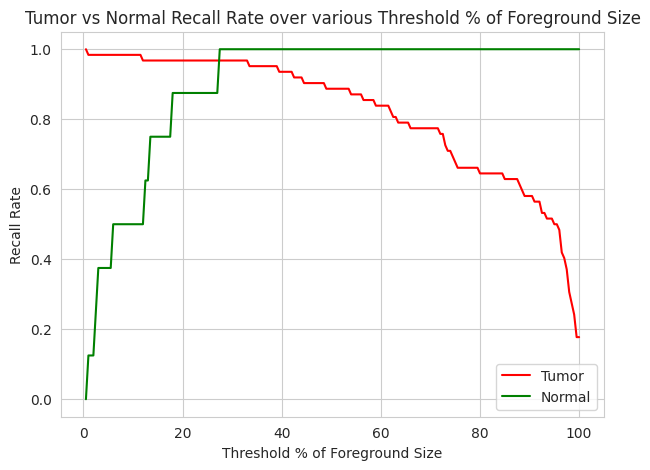

<Figure size 640x480 with 0 Axes>

In [30]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(7, 5))
x_vals = [0.5 * i for i in range(1, 201)]
plt.plot(x_vals, mal_recall, linestyle    ='-', color='red', label='Tumor')
plt.plot(x_vals, ben_recall, linestyle='-', color='green', label='Normal')
plt.xlabel('Threshold % of Foreground Size')
plt.ylabel('Recall Rate')
plt.title('Tumor vs Normal Recall Rate over various Threshold % of Foreground Size')
plt.legend(loc="lower right")
plt.show()
plt.clf()


In [71]:
print(classification_report(np.array(cancer_statuses),iteration_list[60]))

              precision    recall  f1-score   support

           B       0.80      1.00      0.89         8
           M       1.00      0.97      0.98        62

    accuracy                           0.97        70
   macro avg       0.90      0.98      0.94        70
weighted avg       0.98      0.97      0.97        70



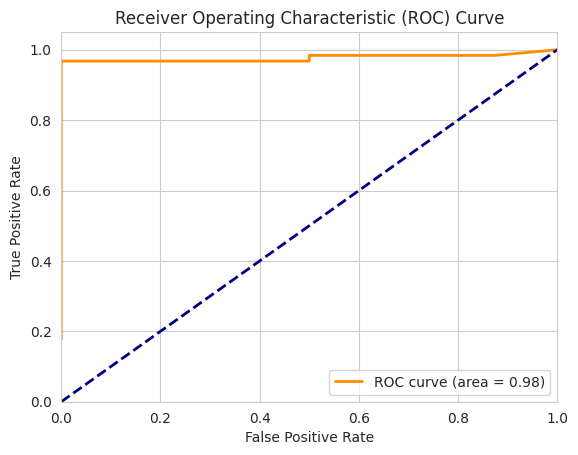

In [45]:
TPR = mal_recall
FPR = [1 - recall for recall in ben_recall]
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.figure()
plt.plot(FPR, TPR, color='darkorange', lw=2, label=f'ROC curve (area = {auc(FPR, TPR):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [17]:
def load_maps(custom_str, pred_dir, heat_dir):
    pred_map = np.load(os.path.join(pred_dir, f"{custom_str}.npy"))
    heat_map = np.load(os.path.join(heat_dir, f"{custom_str}.npy"))
    return pred_map, heat_map

def process_map(pred_map, heat_map, thres):
    pred_map = np.multiply(pred_map, heat_map)
    mask = (pred_map < 0.50) & (-0.50 < pred_map)
    pred_map[mask] = 0
    pred_map[pred_map > 0] = 1
    pred_map[pred_map < 0] = -1
    
    all_pred_map = np.copy(pred_map)
    all_pred_map[all_pred_map == -1] = 1
    all_pred_pixels = np.count_nonzero(all_pred_map == 1)
    
    mal_pred_map = np.where(pred_map == -1, 0, pred_map)
    ben_pred_map = np.where(pred_map == 1, 0, 1)

    total_mal_pred_space = get_total_space(mal_pred_map)
    total_ben_pred_space = get_total_space(ben_pred_map)

    if total_mal_pred_space >= 0.005 * thres * all_pred_pixels:
        return 'M'
    else:
        return 'B'

def get_total_space(pred_map):
    pred_map = pred_map.astype(np.uint8)
    pred_background = (pred_map.shape[0] * pred_map.shape[1]) - np.count_nonzero(pred_map)

    connectivity = 8
    output = cv2.connectedComponentsWithStats(pred_map, connectivity, cv2.CV_32S)
    num_labels, _, stats, _ = output

    return sum([stats[num, cv2.CC_STAT_AREA] for num in range(num_labels) if stats[num, cv2.CC_STAT_AREA] != pred_background])

def get_trend(mode, typ, truths):
    return [
        classification_report(np.array(truths), i, output_dict=True)[mode][typ]
        for i in iteration_list
    ]

# Variables
pred_dir = PRED_GRID_MAP_DIR
heat_dir = GRADCAM_GRID_MAP_DIR
custom_str_list = [f"{subject}_{side}" for subject, side in zip(subjects, sides)]

# Main loop
#iteration_list = [process_map(*load_maps(custom_str, pred_dir, heat_dir), thres) for custom_str in custom_str_list for thres in range(200)]
iteration_list = [[process_map(*load_maps(custom_str, pred_dir, heat_dir), thres) for thres in range(200)] for custom_str in custom_str_list]
iteration_list = [list(item) for item in zip(*iteration_list)]

# Load data and extract information
# df = pd.read_excel(os.path.join(BASE_PATH, "Specimen Tracking Log and Financial Logs.xlsx"), sheet_name=0)
# extracted_df = df[["Sample #", "Type of Specimen (normal, IDC, ICL, tumor + adj normal)"]].copy()
# extracted_df.columns = ["Patient Subject ID", "Specimen Type"]
# extracted_df["Cancer Status"] = extracted_df["Specimen Type"].apply(lambda x: 'B' if x == 'normal' else 'M')
patient_status_dict = dict(zip(filtered_df["Patient Subject ID"], filtered_df["Cancer Status"]))
cancer_statuses = [patient_status_dict[int(patient_id)] for patient_id in subjects]

# Save results
output_df = pd.DataFrame(iteration_list).transpose()
output_df['Truth'] = cancer_statuses
output_df['Subject'] = subjects
output_df['Side'] = sides
output_df['fullname'] = output_df['Subject'].astype(str) + '_' + output_df['Side'].astype(str)
output_df = output_df.sort_values(by="Subject")
desired_columns_order = ['fullname','Subject', 'Side', 'Truth']
new_column_order = desired_columns_order + [col for col in output_df.columns if col not in desired_columns_order]
output_df = output_df[new_column_order]
output_df.to_csv(os.path.join(BASE_PATH, 'predictions.csv'), index=False)

# Plot results
mal_recall = get_trend('M', 'recall', cancer_statuses)
ben_recall = get_trend('B', 'recall', cancer_statuses)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

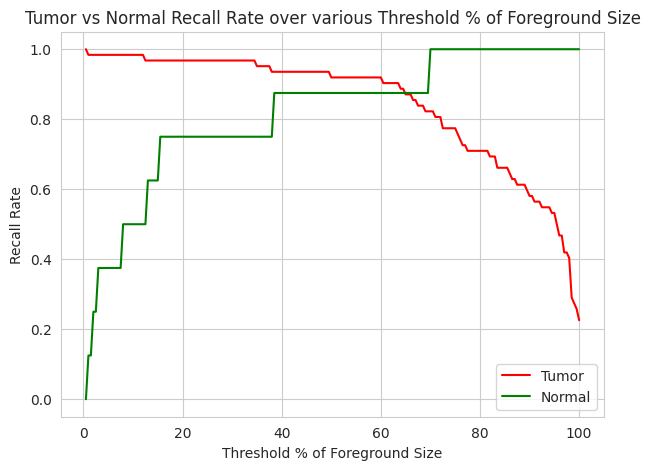

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(7, 5))
x_vals = [0.5 * i for i in range(1, 201)]
plt.plot(x_vals, mal_recall, linestyle    ='-', color='red', label='Tumor')
plt.plot(x_vals, ben_recall, linestyle='-', color='green', label='Normal')
plt.xlabel('Threshold % of Foreground Size')
plt.ylabel('Recall Rate')
plt.title('Tumor vs Normal Recall Rate over various Threshold % of Foreground Size')
plt.legend(loc="lower right")
plt.show()
plt.clf()


In [20]:
print(classification_report(np.array(cancer_statuses),iteration_list[90]))

              precision    recall  f1-score   support

           B       0.64      0.88      0.74         8
           M       0.98      0.94      0.96        62

    accuracy                           0.93        70
   macro avg       0.81      0.91      0.85        70
weighted avg       0.94      0.93      0.93        70



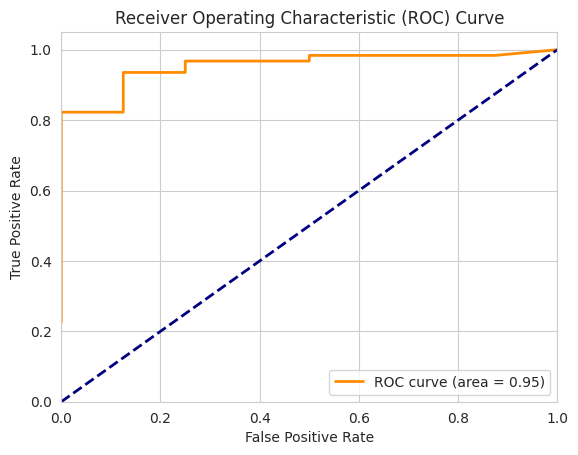

In [26]:
TPR = mal_recall
FPR = [1 - recall for recall in ben_recall]
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.figure()
plt.plot(FPR, TPR, color='darkorange', lw=2, label=f'ROC curve (area = {auc(FPR, TPR):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw

In [22]:
bad_np = []
for z in range(len(sample_paths)):
    custom_str = f"{subjects[z]}_{sides[z]}"
    pred_dir = PRED_GRID_MAP_DIR
    heat_dir = GRADCAM_GRID_MAP_DIR
    
    pred_map = np.load(os.path.join(PRED_GRID_MAP_DIR, f"{custom_str}.npy"))
    heat_map = np.load(os.path.join(GRADCAM_GRID_MAP_DIR, f"{custom_str}.npy"))

    if(pred_map.shape!=heat_map.shape):
        bad_np.append(custom_str)

    combine_np=np.multiply(pred_map,heat_map)
    mask = (combine_np < 0.25) & (combine_np > -0.25)
    combine_np[mask]=0

    mask_mal = (combine_np >= 0.5)
    mask_ben = (combine_np <= -0.5)
    combine_np[mask_mal]=1
    combine_np[mask_ben]=-1

    background = cv2.imread(sample_paths[z])
    h, w = background.shape[0], background.shape[1]    
    height=math.ceil(h/400)*400
    width=math.ceil(w/400)*400
    dim1 = (width,height)
    new_image = cv2.resize(background,dim1,interpolation=cv2.INTER_AREA)

    if (np.any(combine_np == 1) == True) and (np.any(combine_np == -1) == True):
        c_list=['#00FF00','000000','000000','000000','000000','#000000','#000000','#FF0000',]
    elif (np.any(combine_np == 1) == False) and (np.any(combine_np == -1) == True):
        c_list=['#00FF00','000000','000000','000000','000000','#000000','#000000','#000000',]
    elif (np.any(combine_np == 1) == True) and (np.any(combine_np == -1) == False):
        c_list=['000000','000000','000000','000000','000000','#000000','#000000','#FF0000',]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('lala',c_list,N=8)
    ax=sns.heatmap(combine_np,yticklabels=False,xticklabels=False,cmap=cmap,cbar=False)
    figure = ax.get_figure()  

    save_path = os.path.join(PROCESS_PATCHES_DIR, f"{custom_str}map.jpg")
    figure.savefig(save_path, dpi=400)
    plt.close(figure)
    overlay = cv2.imread(save_path)

    w=int(overlay.shape[1])
    h=int(overlay.shape[0])
    dim = (w,h)
    coords=[]
    for x in range(0,w):
        for y in range(0,h):
            if overlay[y,x][0]!=255 and overlay[y,x][1]!=255 and overlay[y,x][2]!=255:
                coords.append((y,x))
    tempt=[]
    templ=[]
    for x in coords:
        tempt.append(x[0])
        templ.append(x[1])
    top = min(tempt)
    bottom = max(tempt)
    left = min(templ)
    right = max(templ)
    im = overlay[top:bottom, left:right]
    im = cv2.resize(im,dim1,interpolation=cv2.INTER_AREA)

    cropped_save_path = os.path.join(PROCESS_PATCHES_DIR, f"{custom_str}cropped.jpg")
    cv2.imwrite(cropped_save_path, im)
    overlay = Image.open(cropped_save_path)

    width=overlay.size[0]
    height=overlay.size[1]
    img = Image.new("RGBA", (width, height))

    draw = ImageDraw.Draw(img)
    for x in range(int(width/400)):
        for y in range(int(height/400)):
            draw.rectangle([((x*400)+30,(y*400)+30),((x*400)+370,(y*400)+370)],fill=(0,0,0),outline=None,width=1)
    overlay.paste(img, (0, 0), img)
    
    grid_save_path = os.path.join(PROCESS_PATCHES_DIR, f"{custom_str}grid.png")
    overlay.save(grid_save_path)
    overlay = cv2.imread(grid_save_path)

    added_image = cv2.addWeighted(new_image,1,overlay,0.5,-10)
    bounding_box_save_path = os.path.join(BOUNDING_BOXES_OVERLAY_DIR, f"{custom_str}boxalt.jpg")
    cv2.imwrite(bounding_box_save_path, added_image)